Machine Intelligence 2 - Exercise 5 - GMM & EM

PBJ Group : Poulami Ghosh, Julie Morgan, Bramantyo Supriyatno 

In [28]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import multivariate_normal

from sklearn.cluster import KMeans

In [29]:
def generate_data(w1, w2, sigma1, sigma2, p1, m=2, n=100):
    p2 = 1.0-p1
    prob = np.random.rand(n)
    
    latent_label = (prob<p1)

    p1_prob = latent_label.astype(float)
    p2_prob = 1.0-p1_prob

    p1_x = np.random.multivariate_normal(w1, np.eye(m) * (sigma1**2), size=n).T
    p2_x = np.random.multivariate_normal(w2, np.eye(m) * (sigma2**2), size=n).T

    ret = np.zeros((2, n))
    
    ret[:,np.where(latent_label)[0]] = p1_x[:,np.where(latent_label)[0]]
    ret[:,np.where(latent_label==False)[0]] = p2_x[:,np.where(latent_label==False)[0]]

    return ret, latent_label.astype(int),

In [30]:
M = 2

w1 = np.array([2, 2])
w2 = np.array([1, 1])

sigma1 = 0.7
sigma2 = 0.2

p1 = 2/3

dataset1, y1 = generate_data(w1, w2, sigma1, sigma2, p1)

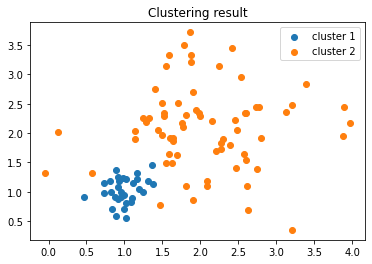

In [31]:
x1 = dataset1[:, np.where(y1==0)[0]]
x2 = dataset1[:, np.where(y1==1)[0]]

plt.scatter(x1[0,:], x1[1,:], label='cluster 1')
plt.scatter(x2[0,:], x2[1,:], label='cluster 2')

plt.legend()
plt.title('Clustering result')
plt.show()

In [32]:
def em_clustering(x, theta=1e-4, w_ext=False, w_ext_val=None, s_ext=False, s_ext_val=None):
    np.random.seed(3)
    m = 2 # x.shape[0]
    q = 2
    n = x.shape[1]
    
    prior = np.ones(q) / m

    mu = np.mean(x, axis=1, keepdims=True)
    

    if not w_ext:
        w1 = mu + np.random.normal(size=mu.shape)
        w2 = mu + np.random.normal(size=mu.shape)

        old_w = [w1, w2] 
    else:
        old_w = w_ext_val
    
    new_w = old_w.copy()


    if not s_ext:
        var = np.mean(np.linalg.norm(x-mu, axis=0)**2)

        ssquared_1 = var + np.random.normal()
        ssquared_2 = var + np.random.normal()

        old_sigma_squared = [ssquared_1, ssquared_2]
    else:
        old_sigma_squared = s_ext_val
    
    new_sigma_squared = old_sigma_squared.copy()


    err = np.inf

    likelihood = np.zeros((q, n))
    posterior = np.zeros((q, n))

    step = 0

    while err>theta:
        for i in range(q):
            for j in range(n):
                likelihood[i,j] = multivariate_normal.pdf(x[:,j], old_w[i].ravel(), old_sigma_squared[i])

        for i in range(q):
            for j in range(n):
                marginal = np.sum([likelihood[r,j] * prior[r] for r in range(m)])

                posterior[i,j] = likelihood[i,j] * prior[i] / marginal 

        # m-step
        for i in range(q):
            nom_w = np.zeros((m,1))
            denom_w = 0

            nom_sigma_squared = 0

            for j in range(n):
                nom_w += posterior[i,j]*x[:,[j]]
                denom_w += posterior[i,j]

                nom_sigma_squared += (np.linalg.norm(x[:,j] - old_w[i].ravel())**2)*posterior[i,j]
            new_w[i] =  nom_w/denom_w
            new_sigma_squared[i] = nom_sigma_squared/(denom_w*m)

        prior = np.mean(posterior, axis=1)

        err = 1
        for i in range(m):
            c_err = np.linalg.norm(new_w[i] - old_w[i])
            if err > c_err:
                err = c_err
        #print('distance: {}'.format(err))

        old_w = new_w.copy()
        old_sigma_squared = new_sigma_squared.copy()
        step+=1

    return old_w, old_sigma_squared, np.argmax(posterior, axis=0)

In [54]:
def bulk_cluster(dataset1, y1):

    fig, ax = plt.subplots(4,1, figsize=(10,8))

    cluster1_results = em_clustering(dataset1)
    x1 = dataset1[:, np.where(cluster1_results[2]==0)]
    x2 = dataset1[:, np.where(cluster1_results[2]==1)]

    ax[0].scatter(x1[0,:], x1[1,:], label='cluster 1')
    ax[0].scatter(x2[0,:], x2[1,:], label='cluster 2')

    ax[0].legend()
    ax[0].set_title('EM Clustering result')
    # plt.show()

    cluster1_error = np.mean(y1==cluster1_results[2])
    print('\n ME clustering error: {}'.format(cluster1_error))

    kmeans1 = KMeans(n_clusters=2)
    kmeans_cluster = kmeans1.fit_predict(dataset1.T)

    x1 = dataset1[:, np.where(kmeans_cluster==0)[0]]
    x2 = dataset1[:, np.where(kmeans_cluster==1)[0]]

    ax[1].scatter(x1[0,:], x1[1,:], label='cluster 1')
    ax[1].scatter(x2[0,:], x2[1,:], label='cluster 2')

    ax[1].legend()
    ax[1].set_title('kMeans Clustering result')
    # plt.show()

    kmeans_cluster_error = np.mean(y1!=kmeans_cluster) # cluster differences
    print('\n kMeans clustering error: {}'.format(kmeans_cluster_error))

    k_means_w = [kmeans1.cluster_centers_[0],kmeans1.cluster_centers_[1]]

    cluster1_results = em_clustering(dataset1, w_ext=True,w_ext_val=k_means_w)
    x1 = dataset1[:, np.where(cluster1_results[2]==0)]
    x2 = dataset1[:, np.where(cluster1_results[2]==1)]

    ax[2].scatter(x1[0,:], x1[1,:], label='cluster 1')
    ax[2].scatter(x2[0,:], x2[1,:], label='cluster 2')

    ax[2].legend()
    ax[2].set_title('EM Clustering result (k-means informed w)')
    # plt.show()

    cluster1_error = np.mean(y1==cluster1_results[2])
    print('\n ME clustering error: {}'.format(cluster1_error))

    x1 = dataset1[:, np.where(kmeans_cluster==0)]
    x2 = dataset1[:, np.where(kmeans_cluster==1)]

    kmeans_sigma1 = np.var(x1)
    kmeans_sigma2 = np.var(x2)

    k_means_sigma=[kmeans_sigma1, kmeans_sigma2]

    cluster1_results = em_clustering(dataset1, s_ext=True,s_ext_val=k_means_sigma)
    x1 = dataset1[:, np.where(cluster1_results[2]==0)]
    x2 = dataset1[:, np.where(cluster1_results[2]==1)]

    ax[3].scatter(x1[0,:], x1[1,:], label='cluster 1')
    ax[3].scatter(x2[0,:], x2[1,:], label='cluster 2')

    ax[3].legend()
    ax[3].set_title('EM Clustering result (k-means informed var)')
    
    # ax[3].show()

    fig.tight_layout()
    cluster1_error = np.mean(y1==cluster1_results[2])
    print('\n ME clustering error: {}'.format(cluster1_error))


 ME clustering error: 0.02

 kMeans clustering error: 0.85

 ME clustering error: 0.02

 ME clustering error: 0.02


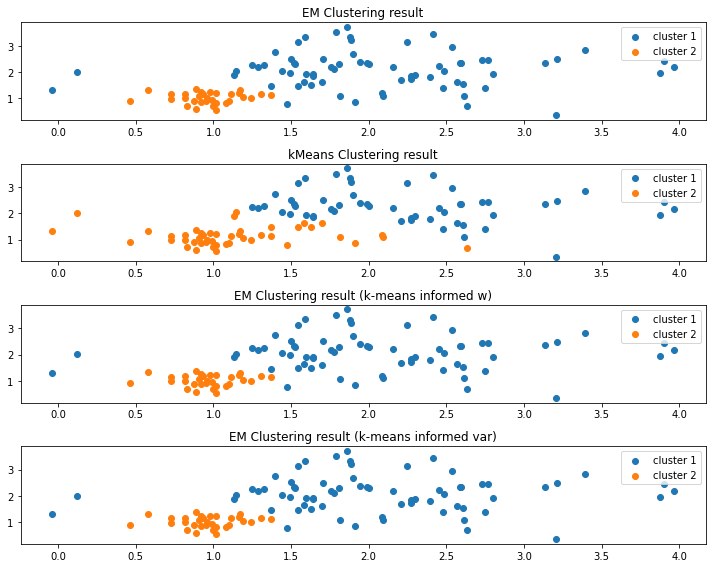

In [55]:
bulk_cluster(dataset1, y1)


 ME clustering error: 0.0

 kMeans clustering error: 1.0

 ME clustering error: 0.0

 ME clustering error: 0.69


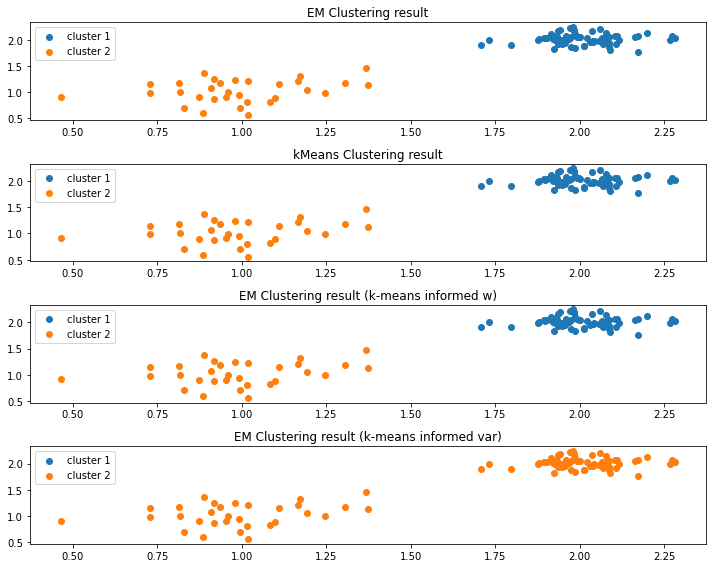

In [57]:

sigma1 = 0.1

dataset2, y2 = generate_data(w1, w2, sigma1, sigma2, p1)
bulk_cluster(dataset2, y2)


 ME clustering error: 0.03

 kMeans clustering error: 0.96

 ME clustering error: 0.03

 ME clustering error: 0.03


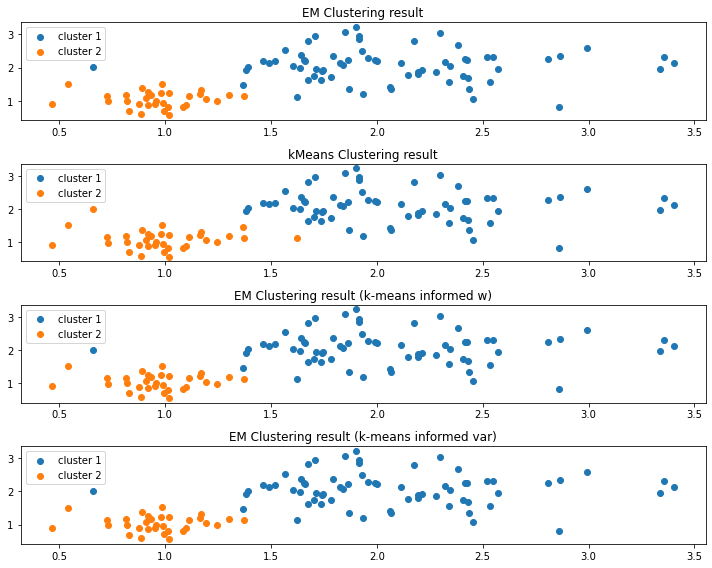

In [58]:

sigma1 = 0.5

dataset2, y2 = generate_data(w1, w2, sigma1, sigma2, p1)
bulk_cluster(dataset2, y2)


 ME clustering error: 0.0

 kMeans clustering error: 1.0

 ME clustering error: 0.0

 ME clustering error: 0.69


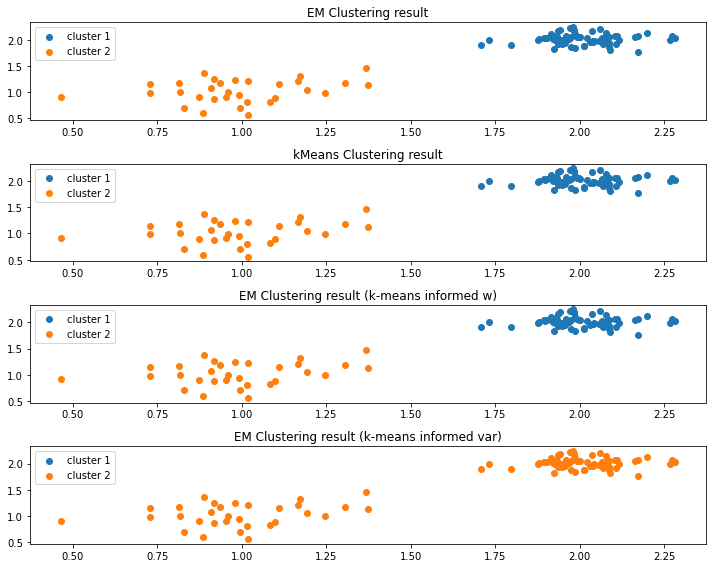

In [59]:

sigma1 = 0.1

dataset2, y2 = generate_data(w1, w2, sigma1, sigma2, p1)
bulk_cluster(dataset2, y2)


 ME clustering error: 0.05

 kMeans clustering error: 0.38

 ME clustering error: 0.95

 ME clustering error: 0.05


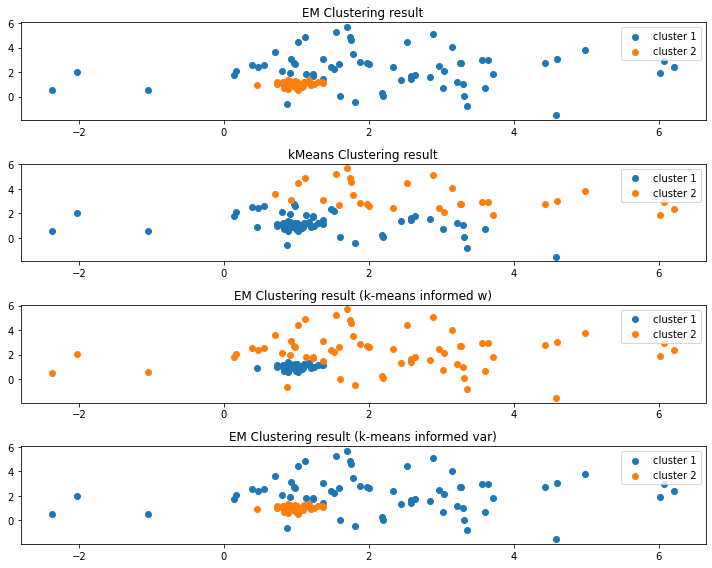

In [60]:

sigma1 = 1.5

dataset2, y2 = generate_data(w1, w2, sigma1, sigma2, p1)
bulk_cluster(dataset2, y2)